In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import scipy 
from scipy import stats
import iminuit
from iminuit import Minuit

mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")
#plt.rc("text", usetex=True)

save_plots = True
verbose = False

In [2]:
data_posi = pd.read_csv("../overvaagningsdata-covid19-28042021-yt76/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)
data_test = pd.read_csv("../overvaagningsdata-covid19-28042021-yt76/Municipality_tested_persons_time_series.csv", sep=';', thousands='.', index_col=0)

# Print how much data is included:
date_start = "2020-08-03"            # This is thus day 0 #Starting on a Monday
date_end = "2020-12-13"              # Ending on a Sunday # 19 Weeks
print("  Data used: ", date_start, "-", date_end)    

# Number of Positives (P) and Tests (T) for all of Denmark ("all")
P_all = data_posi.loc[date_start:date_end].sum(axis=1)
eP_all = np.sqrt(P_all)
T_all = data_test.loc[date_start:date_end].sum(axis=1)
eT_all = np.sqrt(T_all)

  Data used:  2020-08-03 - 2020-12-13


In [3]:
# Average time between generations (in days):
tG = 4.7

# Number of positive tests and uncertainty, assuming fixed number of daily tests and power law correction:
Power = -0.50

# Correct for effects of weekdays, corrects from 2nd January forward:
frac = [-0.00615632,0.05407795,0.04774371,0.00812457, 0.00122933, -0.01823577,-0.0527193 ]    # Based on 1st of August to 24th of December
frac_fra_lørdag = np.roll(frac, 0)    # This corresponds to 1st of January being a Friday (=4)

# To account for larger uncertainties in positives in data than simply the statistical:
SystError = 0.0                      # Should be included at some point
SystErrorScale = 1.0                 # 1.0 (i.e. doubling of error) works OK!

In [4]:
# These are also the days where corrections are applied:
Plot_StartDay = 0         # 1st of August 2020
Plot_EndDay   = len(P_all)

# Calculate the Scaled Positives (SP):
nAveDailyTests_all = T_all.mean()
fPos_all = P_all / T_all
efPos_all = np.sqrt(fPos_all*(1.0-fPos_all)/T_all + SystError**2)
eP_all  = np.sqrt(T_all*fPos_all*(1-fPos_all)) * (1.0 + SystErrorScale)
SP_all  = P_all  * (T_all / nAveDailyTests_all)**Power
eSP_all = eP_all * (T_all / nAveDailyTests_all)**Power

# Calculate the Scaled CORRECTED Positives (SCP), i.e. apply correction for weekdays:
SCP_all = np.zeros_like(SP_all)
eSCP_all = np.zeros_like(eSP_all)
for i,x,dx in zip(np.arange(Plot_StartDay,Plot_StartDay+len(SP_all[Plot_StartDay:Plot_EndDay])),
                  SP_all[Plot_StartDay:Plot_EndDay], eSP_all[Plot_StartDay:Plot_EndDay]) :
    factor = 1.0               # Just for testing, if the "strength" of the effect is reasonable
    SCP_all[i] = x*(1 - factor * frac_fra_lørdag[i%7])
    eSCP_all[i] = dx*(1 - factor * frac_fra_lørdag[i%7])

# Print the data used for fits:
if verbose:
    print("Average number of PCR tests: ", nAveDailyTests_all)
    print(" Date      Ntest      Nposi (P)    SP         SCP")
    for i in range(len(T_all)) :
        # date_of_month = td.
        print(f"{i+1:4d}   {T_all[i]:10d}  {P_all[i]:8d}    {SP_all[i]:8.0f}   {SCP_all[i]:8.0f}")

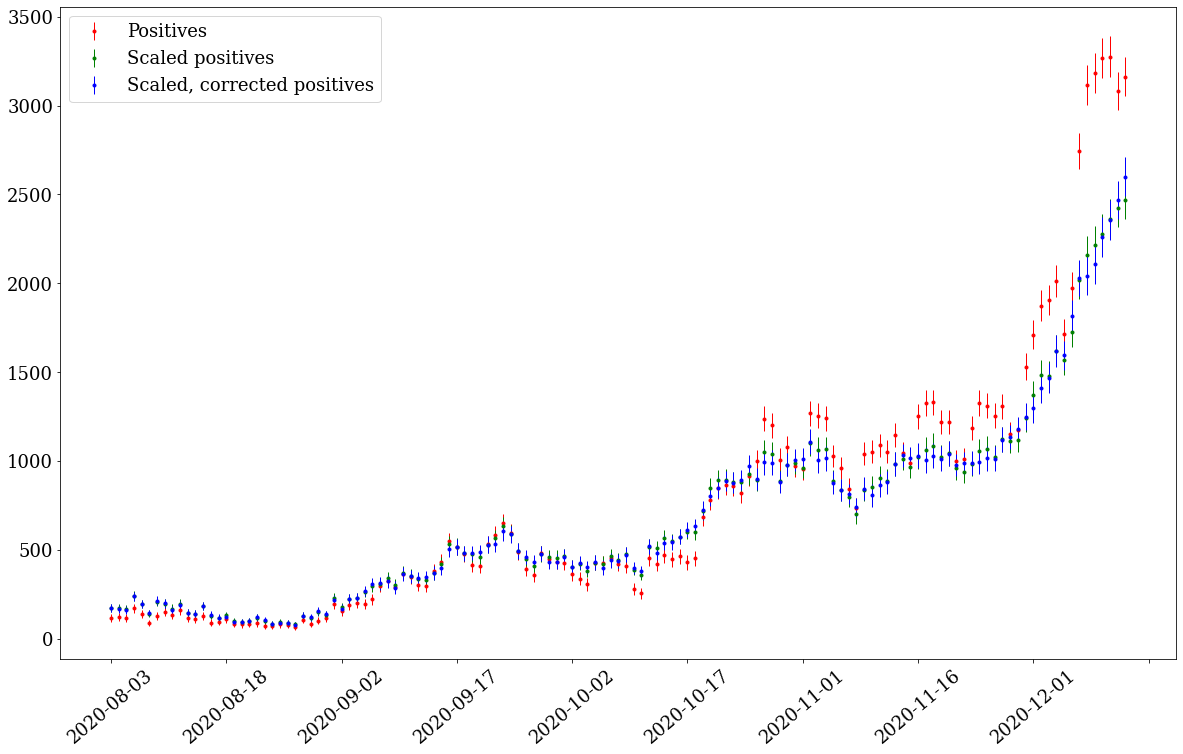

In [5]:
days = np.arange(Plot_EndDay)

fig, ax = plt.subplots(figsize=(20,12))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
for label in ax.get_xticklabels():
        label.set_rotation(40)
ax.errorbar(P_all.index, P_all,yerr=eP_all,fmt='.', linewidth=1, label='Positives', color='red')
ax.errorbar(P_all.index, SP_all,yerr=eP_all,fmt='.', linewidth=1, label='Scaled positives', color='green')
ax.errorbar(P_all.index, SCP_all,yerr=eP_all,fmt='.', linewidth=1, label='Scaled, corrected positives', color='blue')
ax.legend(loc='best')
plt.show()

In [6]:
# "Analytic" R
#Errors are errors on a fraction
#Using first and last point in the data
R_simple = (SCP_all[-1] / SCP_all[0]) ** (tG / Plot_EndDay)
R_sim_err = (SCP_all[-1] / SCP_all[0] * np.sqrt((eSCP_all[-1] / SCP_all[-1]) ** 2 + (eSCP_all[0] / SCP_all[0]) ** 2)) ** (tG / Plot_EndDay)

#Using the spike at mid-december (the highest point on the curve)
R_max = (np.max(SCP_all) / SCP_all[0]) ** (tG / np.argmax(SCP_all))
R_max_err = (np.max(SCP_all) / SCP_all[0] * np.sqrt(eSCP_all[np.argmax(SCP_all)] / np.max(SCP_all)) ** 2 + (eSCP_all[0] / SCP_all[0]) ** 2) ** (tG / np.argmax(SCP_all))

print(f"Using first and last: R= {R_simple:.4f} +/- {R_sim_err:.4f}")#These errors seem wrong
print(f"Using largest spike: R= {R_max:.4f} +/- {R_max_err:.4f}")

Using first and last: R= 1.1000 +/- 1.0369
Using largest spike: R= 1.1008 +/- 0.9791


Day 3 for PCR is not valid!
Prob(Chi2=  5.5, Ndof= 5) = 0.363
Rt fit = 1.083 +- 0.175
S0 fit = 181.264 +- 12.316 with start value 238.544


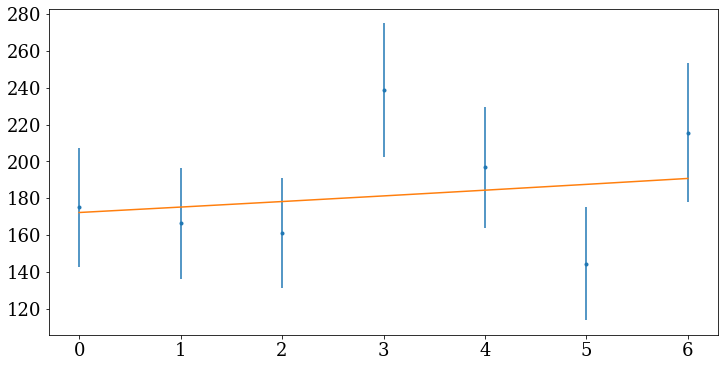

Day 10 for PCR is not valid!
Prob(Chi2=  3.0, Ndof= 5) = 0.697
Rt fit = 0.809 +- 0.136
S0 fit = 161.307 +- 11.000 with start value 143.684


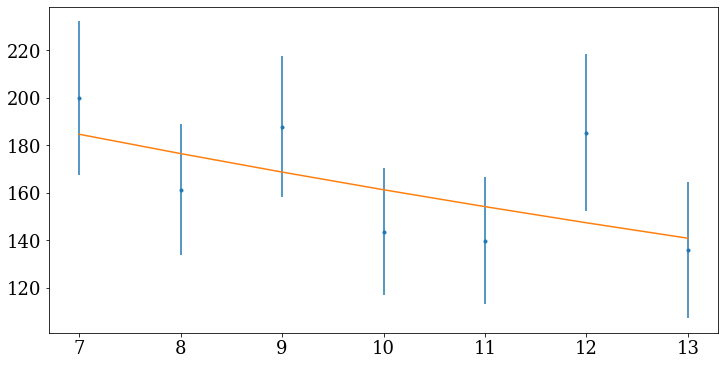

Day 17 for PCR is not valid!
Prob(Chi2=  1.8, Ndof= 5) = 0.881
Rt fit = 0.940 +- 0.196
S0 fit = 107.020 +- 8.689 with start value 94.578


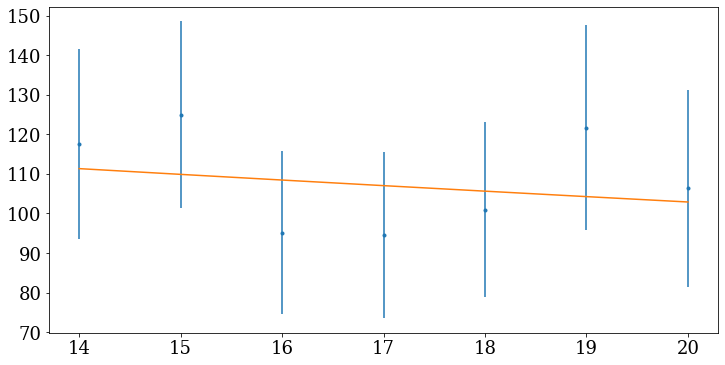

Day 24 for PCR is not valid!
Prob(Chi2=  2.5, Ndof= 5) = 0.778
Rt fit = 1.674 +- 0.362
S0 fit = 102.111 +- 8.502 with start value 79.972


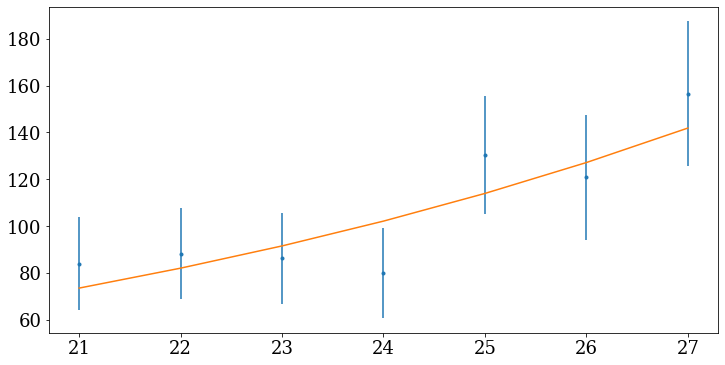

Day 31 for PCR is not valid!
Prob(Chi2=  3.5, Ndof= 5) = 0.618
Rt fit = 1.724 +- 0.235
S0 fit = 214.010 +- 12.132 with start value 221.868


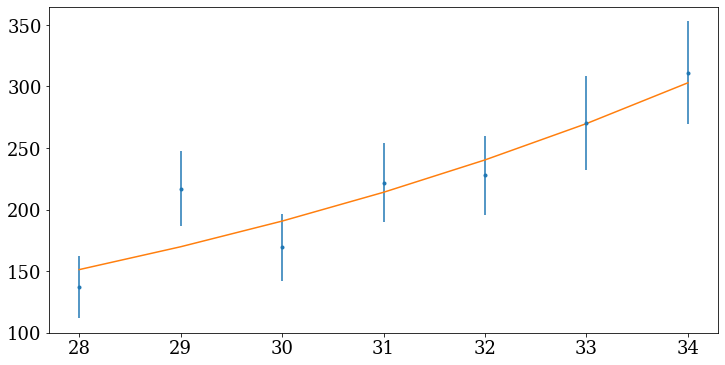

Day 38 for PCR is not valid!
Prob(Chi2=  2.1, Ndof= 5) = 0.836
Rt fit = 1.123 +- 0.113
S0 fit = 332.207 +- 14.067 with start value 366.012


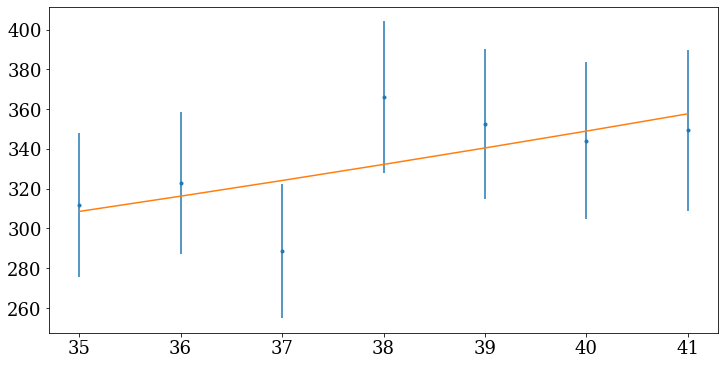

Day 45 for PCR is not valid!
Prob(Chi2=  5.6, Ndof= 5) = 0.349
Rt fit = 1.212 +- 0.097
S0 fit = 459.828 +- 16.291 with start value 515.090


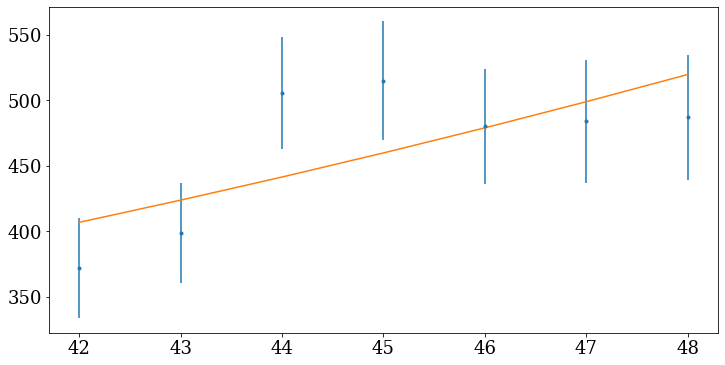

Day 52 for PCR is not valid!
Prob(Chi2=  6.2, Ndof= 5) = 0.291
Rt fit = 0.848 +- 0.065
S0 fit = 517.470 +- 17.380 with start value 587.243


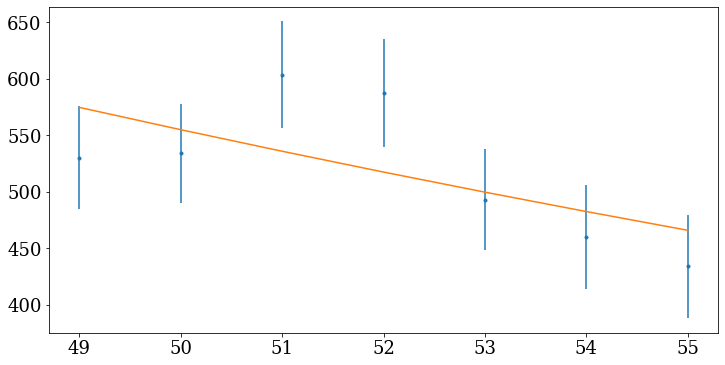

Day 59 for PCR is not valid!
Prob(Chi2=  1.1, Ndof= 5) = 0.951
Rt fit = 0.902 +- 0.082
S0 fit = 433.463 +- 16.494 with start value 461.663


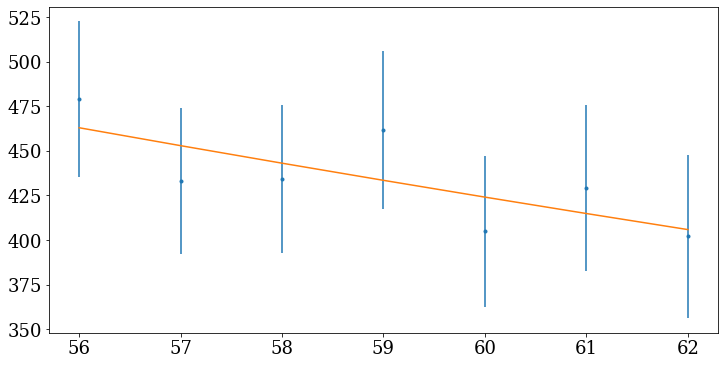

Day 66 for PCR is not valid!
Prob(Chi2=  2.9, Ndof= 5) = 0.716
Rt fit = 0.962 +- 0.087
S0 fit = 422.054 +- 16.487 with start value 437.798


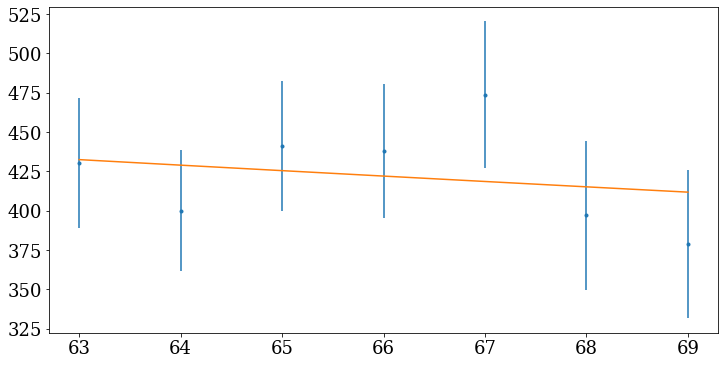

Day 73 for PCR is not valid!
Prob(Chi2=  0.9, Ndof= 5) = 0.969
Rt fit = 1.210 +- 0.103
S0 fit = 555.672 +- 19.701 with start value 543.690


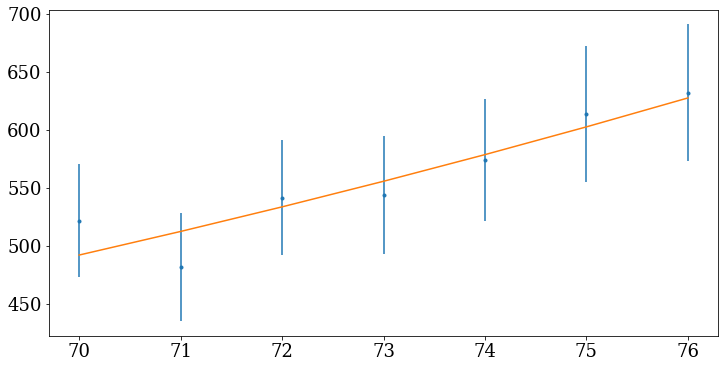

Day 80 for PCR is not valid!
Prob(Chi2=  1.3, Ndof= 5) = 0.932
Rt fit = 1.208 +- 0.074
S0 fit = 855.938 +- 22.397 with start value 887.222


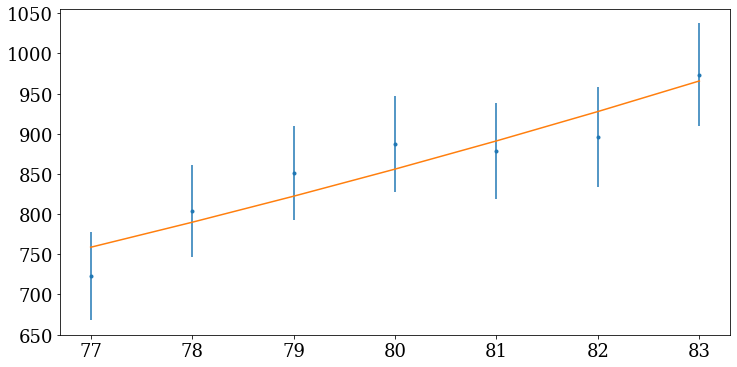

Day 87 for PCR is not valid!
Prob(Chi2=  4.0, Ndof= 5) = 0.552
Rt fit = 1.060 +- 0.059
S0 fit = 964.549 +- 22.212 with start value 881.444


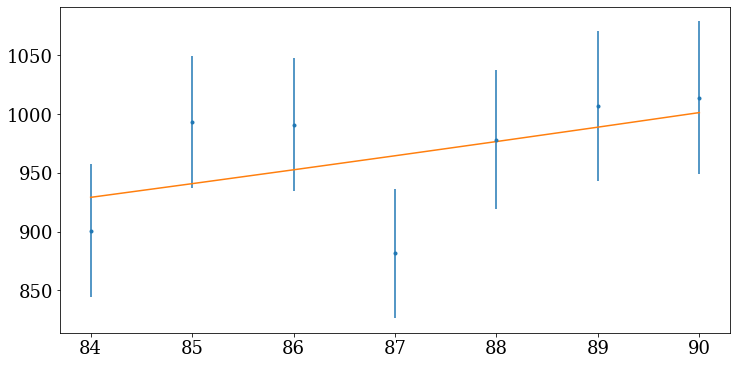

Day 94 for PCR is not valid!
Prob(Chi2=  1.4, Ndof= 5) = 0.924
Rt fit = 0.736 +- 0.041
S0 fit = 905.366 +- 21.362 with start value 878.153


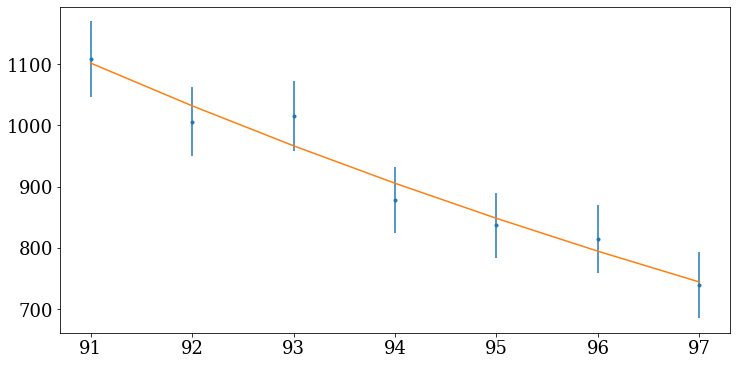

Day 101 for PCR is not valid!
Prob(Chi2=  2.2, Ndof= 5) = 0.825
Rt fit = 1.224 +- 0.068
S0 fit = 913.944 +- 21.077 with start value 881.801


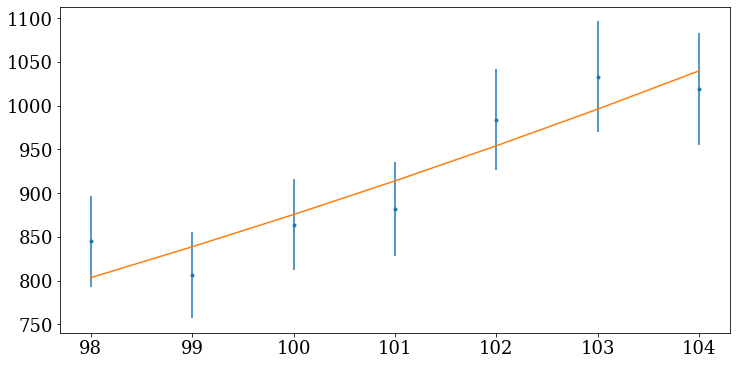

Day 108 for PCR is not valid!
Prob(Chi2=  0.7, Ndof= 5) = 0.983
Rt fit = 0.974 +- 0.050
S0 fit = 1012.583 +- 22.059 with start value 1013.954


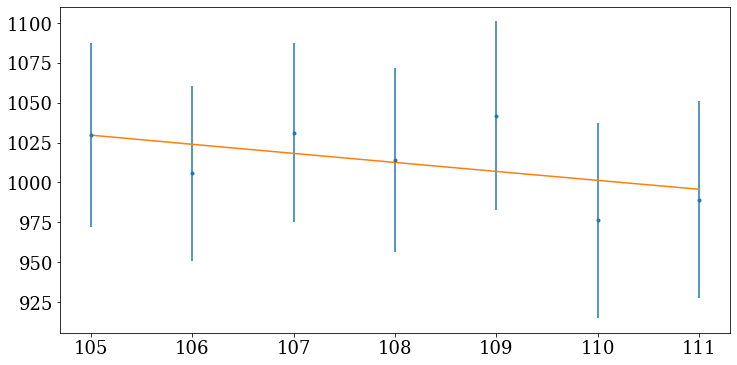

Day 115 for PCR is not valid!
Prob(Chi2=  1.2, Ndof= 5) = 0.949
Rt fit = 1.161 +- 0.060
S0 fit = 1060.358 +- 22.531 with start value 1012.364


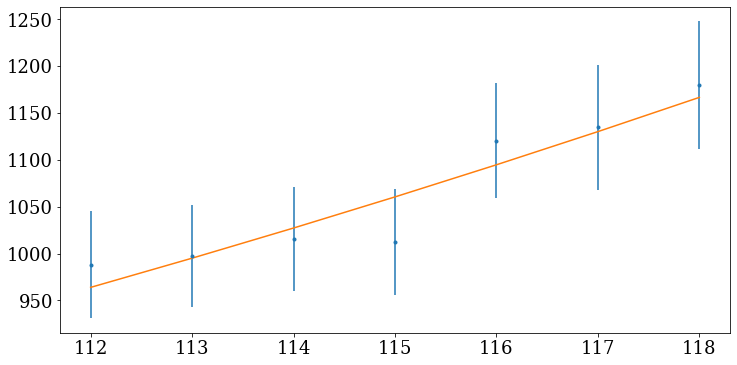

Day 122 for PCR is not valid!
Prob(Chi2=  1.9, Ndof= 5) = 0.865
Rt fit = 1.327 +- 0.056
S0 fit = 1482.739 +- 26.037 with start value 1466.572


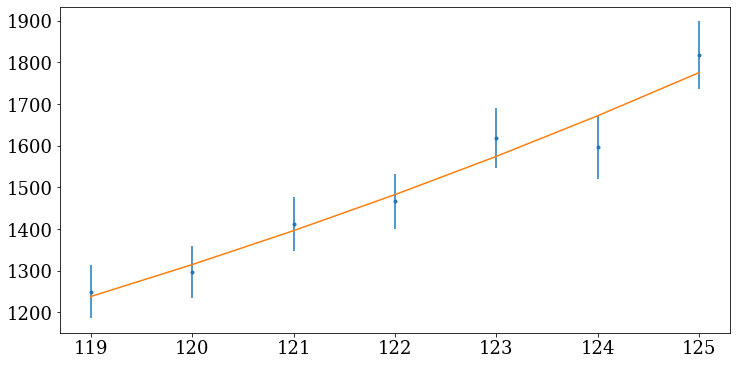

Day 129 for PCR is not valid!
Prob(Chi2=  1.2, Ndof= 5) = 0.949
Rt fit = 1.234 +- 0.040
S0 fit = 2255.296 +- 30.053 with start value 2258.664


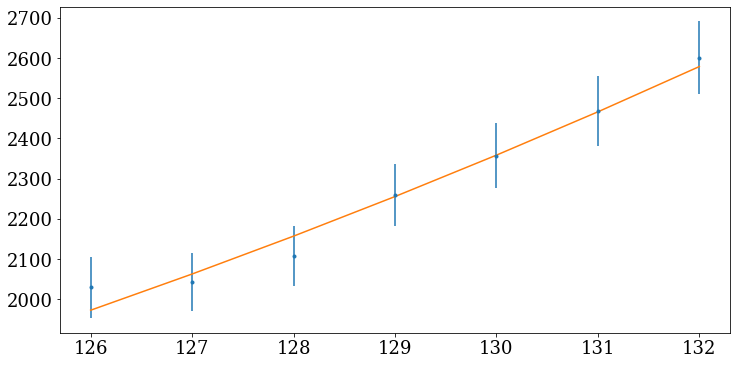

In [7]:
#Interval of days to be fitted for each R
n = 7
k = int((n-1)/2) #Used to get interval

#Weighted average:
#n=13: Rt = 1.0343 +/- 0.0021
#n=11: Rt = 1.0160 +/- 0.0026
#n=9: Rt = 0.99914 +/- 0.0034
#n=7: Rt = 0.9846 +/- 0.0049

#Average:
#n=13: Rt = 1.1045
#n=11: Rt = 1.1032
#n=9: Rt = 1.1035
#N=7: Rt =  1.1070

RPCR_t, RPCR_t_err = [], [] #R and errors on R

for i in range(k, Plot_EndDay-k,7):
    xfit = days[i-k:i+k+1]
    yfit = SCP_all[i-k:i+k+1]
    y_err = eSCP_all[i-k:i+k+1]
    # Exponential function with base Rt:
    def func_Expo(x, S0, Rt, t0, tG) :
    # NOTE: tG = time_generation, i.e. average time between generations.
        return S0 * Rt**((x-t0)/tG)

    # ChiSquare fit model:
    def chi2_calc0(S0, Rt, t0, tG) :
        y_fit = func_Expo(xfit, S0, Rt, t0, tG)
        chi2 = np.sum(((yfit - y_fit) / y_err)**2)
        return chi2

    minuit0 = Minuit(chi2_calc0, S0=SCP_all[i], Rt=1.0, t0=i, fix_t0=True, tG=4.7, fix_tG=True, print_level=0, errordef=1.0)
    minuit0.migrad();                                                  
    
    
    # Here we extract the fitting parameters and their errors
    S0_fit = minuit0.values['S0'];       sigma_S0_fit = minuit0.errors['S0']
    Rt_fit = minuit0.values['Rt'];       sigma_Rt_fit = minuit0.errors['Rt']
    t0_fit = minuit0.values['t0'];       sigma_t0_fit = minuit0.errors['t0']
    tG_fit = minuit0.values['tG'];       sigma_tG_fit = minuit0.errors['tG']
    
    RPCR_t.append(Rt_fit)
    RPCR_t_err.append(sigma_Rt_fit)
    
    # Calcuate fit quality:
    Chi2_fit = minuit0.fval       # The Chi2 value
    Npoints = len(xfit) # Number of points fitted
    Nvar = 2                      # Number of variables (tG is fixed!)
    Ndof_fit = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom
    #p_fac.append(-np.log10(Prob_fit / (1-Prob_fit)))
    #For testing
    #print(f"  Prob(Chi2={Chi2_fit:5.1f}, Ndof={Ndof_fit:2d}) = {Prob_fit:5.3f}")
    #print(f"  Rt fit = {minuit0.values['Rt']:5.3f} +- {minuit0.errors['Rt']:5.3f}")
    if True:
        print(f"Day {i:d} for PCR is not valid!")
        print(f"Prob(Chi2={Chi2_fit:5.1f}, Ndof={Ndof_fit:2d}) = {Prob_fit:5.3f}")
        print(f"Rt fit = {minuit0.values['Rt']:5.3f} +- {minuit0.errors['Rt']:5.3f}")
        print(f"S0 fit = {minuit0.values['S0']:5.3f} +- {minuit0.errors['S0']:5.3f} with start value {SCP_all[i]:5.3f}")
        fig, ax = plt.subplots(figsize=(12,6))
        ax.errorbar(xfit,yfit,yerr=y_err,fmt='.')
        ax.plot(xfit,func_Expo(xfit,S0_fit,Rt_fit,t0_fit,tG_fit))
        plt.show()

In [8]:
def ChiSquareMean(val, err): #From AppStat
    f_app = np.sum(val / err ** 2) / np.sum(1 / err ** 2)
    f_err = 1 / np.sqrt(np.sum(1 / err ** 2))
    Chi2 = np.sum((val - f_app) ** 2 / err ** 2)
    p = stats.chi2.sf(Chi2, val.size - 1)
    return f_app, f_err, Chi2, p

Rt, Rt_err = np.array(RPCR_t), np.array(RPCR_t_err)

print(Rt.mean())

print(ChiSquareMean(Rt,Rt_err))

1.1268524766494348
(1.0625441850176425, 0.016147511546159597, 154.35388404260271, 1.0560463891819046e-23)


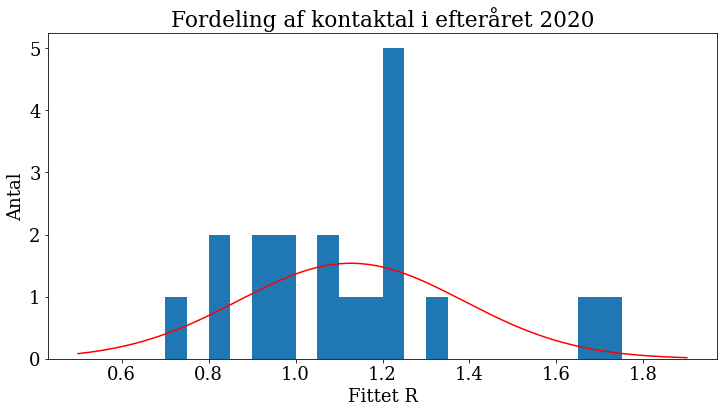

The average R in the fall is 1.127 +/- 0.2595


In [12]:
xplot = np.linspace(0.5,1.9,1000)
sigma = np.std(np.array(RPCR_t),ddof=1)
mean= np.array(RPCR_t).mean()


fig, ax=plt.subplots(figsize=(12,6))
ax.plot(xplot,stats.norm.pdf(xplot,loc=mean, scale = sigma),color='red')
ax.hist(RPCR_t,bins=24,range=(0.6,1.8))
ax.set(xlabel="Fittet R",ylabel="Antal",title="Fordeling af kontaktal i efteråret 2020")
plt.show()
print(f"The average R in the fall is {mean:.3f} +/- {sigma:.4f}")

['Week 32', 'Week 33', 'Week 34', 'Week 35', 'Week 36', 'Week 37', 'Week 38', 'Week 39', 'Week 40', 'Week 41', 'Week 42', 'Week 43', 'Week 44', 'Week 45', 'Week 46', 'Week 47', 'Week 48', 'Week 49', 'Week 50']


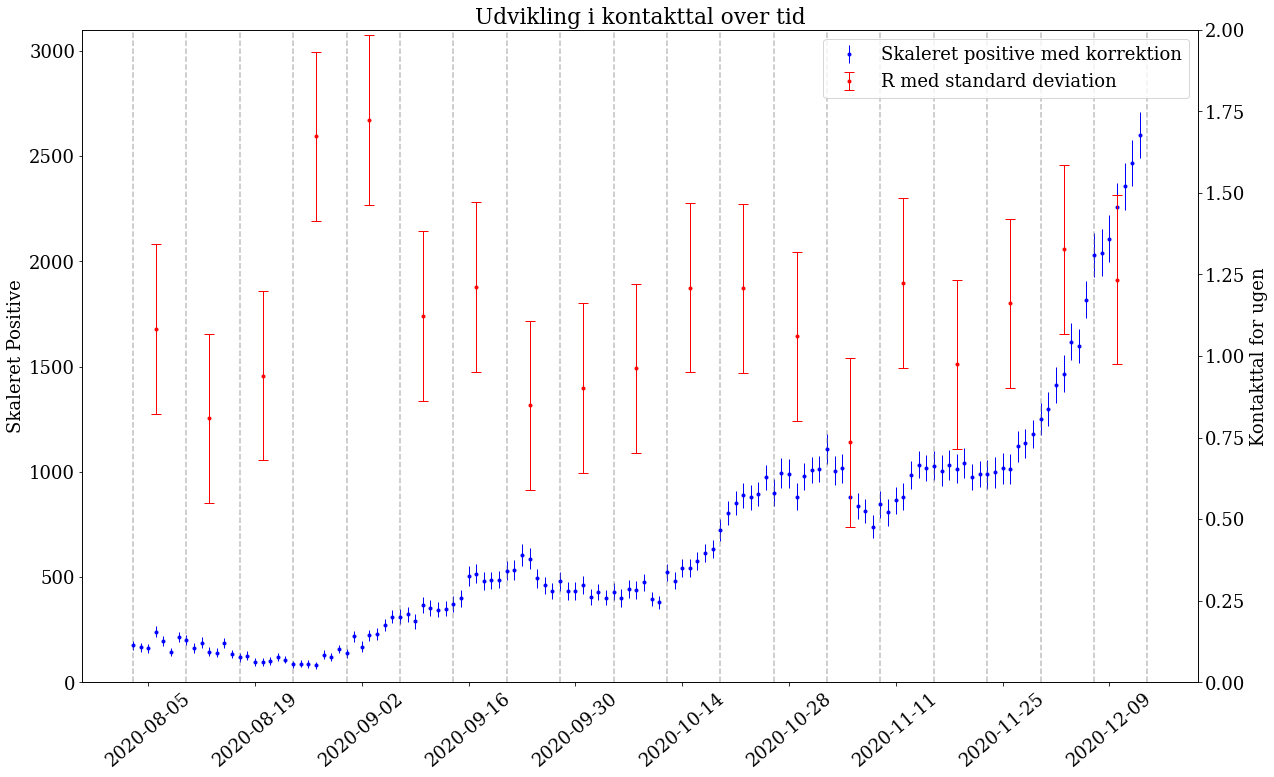

In [14]:
Rlabels = [dt.datetime.strptime(date_start,"%Y-%m-%d") + dt.timedelta(days=i+3) for i in range(0,Plot_EndDay,7)]
index_labels = [dt.datetime.strptime(i,"%Y-%m-%d") for i in P_all.index]
week_labels = ["Week " + str(32 + i) for i in range(19)]

print(week_labels)

fig, ax = plt.subplots(figsize=(20,12))
ax.errorbar(index_labels, SCP_all,yerr=eP_all,fmt='.', linewidth=1, label='Skaleret positive med korrektion', color='blue')
for i in range(0,Plot_EndDay+7,7):
    monday = dt.datetime.strptime(date_start,"%Y-%m-%d") + dt.timedelta(days=i)
    ax.vlines(x=monday,linestyle='--',color='gray',ymin=0,ymax=max(SCP_all)+500,alpha=0.5)
ax.set(ylim=(0,max(SCP_all)+500),ylabel="Skaleret Positive")
ax2 = ax.twinx()
ax2.errorbar(Rlabels, RPCR_t,sigma,fmt='.', linewidth=1, label='R med standard deviation', color='red',capsize=5)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax2.set(ylim=(0,2.0),ylabel = "Kontakttal for ugen",title="Udvikling i kontakttal over tid")
ax.tick_params(axis='x', labelrotation = 40)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

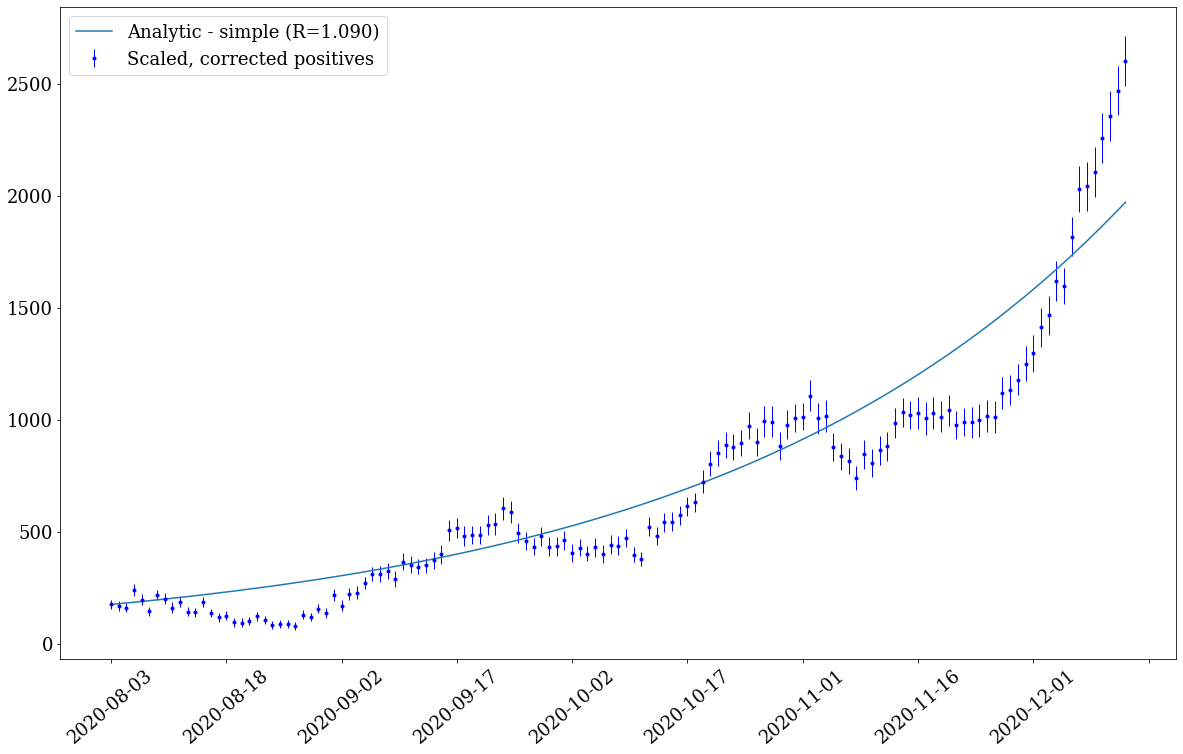

In [11]:
def model(t, R):
    return SCP_all[0] * R ** (t / tG)

fig, ax = plt.subplots(figsize=(20,12))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
for label in ax.get_xticklabels():
        label.set_rotation(40)
ax.errorbar(P_all.index, SCP_all,yerr=eP_all,fmt='.', linewidth=1, label='Scaled, corrected positives', color='blue')
ax.plot(days, model(days,1.090),label="Analytic - simple (R=1.090)")
ax.legend(loc='best')
plt.show()